In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you. 

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* Transformer/CNN/<whatever you select> encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language models (for decoder and encoder)

* or just fine-tunning BART/ELECTRA/... ;)

to improve the translation quality. 

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [11]:
path_do_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'

Dataset not found locally. Downloading from github.
--2023-05-10 03:56:00--  https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12905334 (12M) [text/plain]
Saving to: ‘data.txt’

data.txt            100%[===================>]  12.31M  --.-KB/s    in 0.06s   

2023-05-10 03:56:01 (223 MB/s) - ‘data.txt’ saved [12905334/12905334]



Baseline solution BLEU score is quite low. Try to achieve at least __21__ BLEU on the test set. 
The checkpoints are:

* __21__ - minimal score to submit the homework, 30% of points

* __25__ - good score, 70% of points

* __27__ - excellent score, 100% of points

In [7]:
!pip install subword_nmt
!pip install torchtext==0.6.0

In [8]:
# old deprecated code
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import spacy

import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

### Main part
__Here comes the preprocessing. Do not hesitate to use BPE or more complex preprocessing ;)__

In [9]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [12]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

dataset = torchtext.data.TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [14]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500
Unique tokens in source (ru) vocabulary: 9265
Unique tokens in target (en) vocabulary: 6700


In [15]:
TRG.vocab.itos[::1000]


['<unk>', 'addition', 'familia', 'cola', 'ohio', 'sinks', 'magical']

In [16]:
print(vars(train_data.examples[9]))


{'trg': ['located', 'in', 'maceió', ',', 'apartamentos', '&', 'suites', 'ponta', 'verde', 'maceió', 'offers', 'an', 'outdoor', 'pool', '.'], 'src': ['комплекс', 'apartamentos', '&', 'suites', 'ponta', 'verde', 'maceió', 'расположен', 'в', 'городе', 'масейо', '.', 'к', 'услугам', 'гостей', 'открытый', 'бассейн', '.']}


Length distribution in Train data


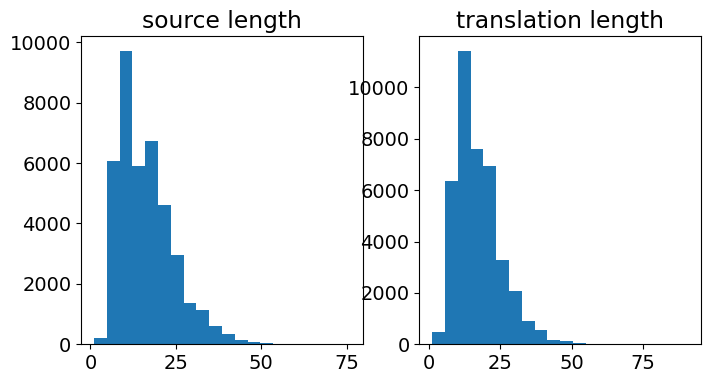

In [17]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

Length distribution in Test data


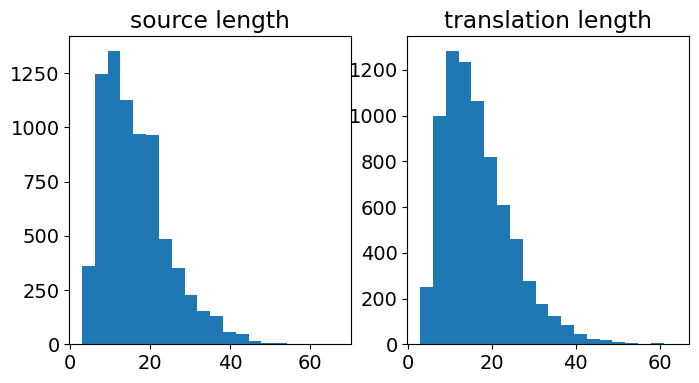

In [18]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);


### Model side
Here comes simple pipeline of NMT model learning. It almost copies the week03 practice

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# device(type='cuda', index=1)
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)
for x in train_iterator:
    break
print(x)
print(x.src.shape, x.trg.shape)

cuda

[torchtext.data.batch.Batch of size 128]
	[.trg]:[torch.cuda.LongTensor of size 62x128 (GPU 0)]
	[.src]:[torch.cuda.LongTensor of size 47x128 (GPU 0)]
torch.Size([47, 128]) torch.Size([62, 128])


In [22]:
import random
import math
import time


class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
#         self.dropout = dropout
        
        self.embedding = nn.Embedding(
            num_embeddings=input_dim,
            embedding_dim=emb_dim
        )
            # <YOUR CODE HERE>
        
        self.rnn = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hid_dim,
            num_layers=n_layers,
            dropout=dropout
        )
            # <YOUR CODE HERE>
        
        self.dropout = nn.Dropout(p=dropout)# <YOUR CODE HERE>
        
    def forward(self, src):
        
        #src = [src sent len, batch size]
        
        # Compute an embedding from the src data and apply dropout to it
        embedded = self.embedding(src)# <YOUR CODE HERE>
        
        embedded = self.dropout(embedded)
        
        output, (hidden, cell) = self.rnn(embedded)
        #embedded = [src sent len, batch size, emb dim]
        
        # Compute the RNN output values of the encoder RNN. 
        # outputs, hidden and cell should be initialized here. Refer to nn.LSTM docs ;)
        
        # <YOUR CODE HERE> 
        
        #outputs = [src sent len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #outputs are always from the top hidden layer
        
        return hidden, cell
    

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.output_dim = output_dim
        self.n_layers = n_layers
        self.dropout = dropout
        
        self.embedding = nn.Embedding(
            num_embeddings=output_dim,
            embedding_dim=emb_dim
        )
            # <YOUR CODE HERE>
        
        self.rnn = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hid_dim,
            num_layers=n_layers,
            dropout=dropout
        )
            # <YOUR CODE HERE>
        
        self.out = nn.Linear(
            in_features=hid_dim,
            out_features=output_dim
        )
            # <YOUR CODE HERE>
        
        self.dropout = nn.Dropout(p=dropout)# <YOUR CODE HERE>
        
    def forward(self, input_, hidden, cell):
        
        #input = [batch size]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #n directions in the decoder will both always be 1, therefore:
        #hidden = [n layers, batch size, hid dim]
        #context = [n layers, batch size, hid dim]
        
        input_ = input_.unsqueeze(0)
        
        #input = [1, batch size]
        
        # Compute an embedding from the input data and apply dropout to it
        embedded = self.dropout(self.embedding(input_))# <YOUR CODE HERE>
        
        #embedded = [1, batch size, emb dim]
        
        # Compute the RNN output values of the encoder RNN. 
        # outputs, hidden and cell should be initialized here. Refer to nn.LSTM docs ;)
        # <YOUR CODE HERE>
        
        
        #output = [sent len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #sent len and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]
        
        
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        prediction = self.out(output.squeeze(0))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden, cell


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src sent len, batch size]
        #trg = [trg sent len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        # Again, now batch is the first dimention instead of zero
        batch_size = trg.shape[1]
        max_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        
        #first input to the decoder is the <sos> tokens
        input_ = trg[0,:]
        
        for t in range(1, max_len):
            
            output, hidden, cell = self.decoder(input_, hidden, cell)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.max(1)[1]
            input_ = (trg[t] if teacher_force else top1)
        
        return outputs

In [23]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)


In [24]:
def init_weights(m):
    # <YOUR CODE HERE>
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9265, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(6700, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=6700, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [25]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 14,880,556 trainable parameters


In [26]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

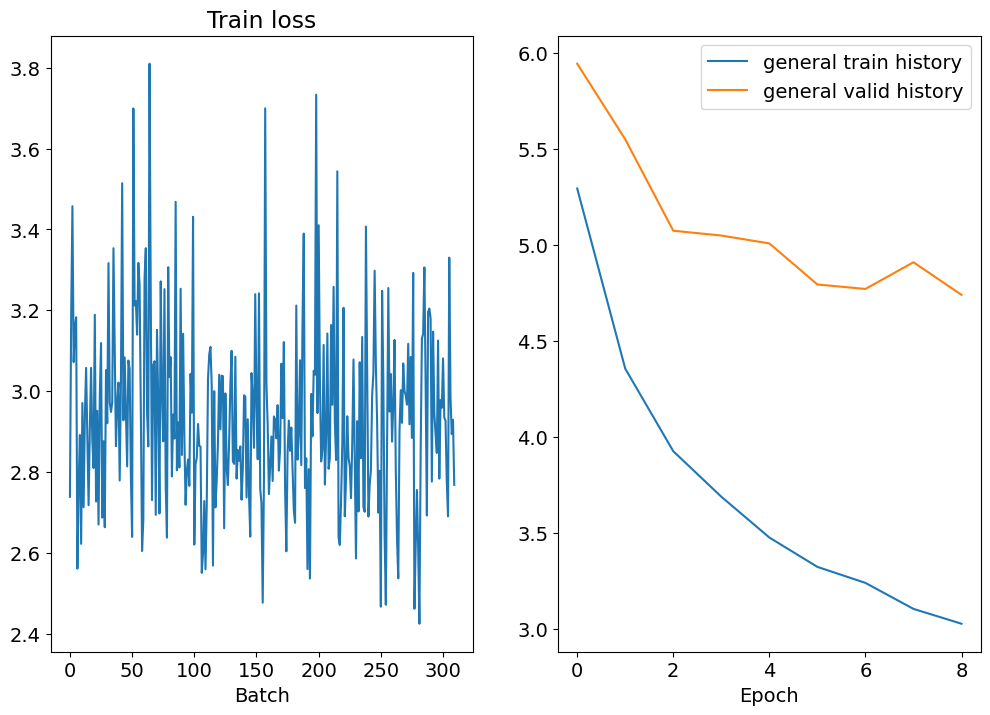

Epoch: 10 | Time: 1m 54s
	Train Loss: 2.934 | Train PPL:  18.798
	 Val. Loss: 4.764 |  Val. PPL: 117.171


In [27]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')


Let's take a look at our network quality:

In [30]:
def flatten(l):
    return [item for sublist in l for item in sublist]

def remove_tech_tokens(mystr, tokens_to_remove=['<eos>', '<sos>', '<unk>', '<pad>']):
    return [x for x in mystr if x not in tokens_to_remove]


def get_text(x, TRG_vocab):
    text = [TRG_vocab.itos[token] for token in x]
    try:
        end_idx = text.index('<eos>')
        text = text[:end_idx]
    except ValueError:
        pass
    text = remove_tech_tokens(text)
    if len(text) < 1:
        text = []
    return text


def generate_translation(src, trg, model, TRG_vocab):
    model.eval()

    output = model(src, trg, 0) #turn off teacher forcing
    output = output.argmax(dim=-1).cpu().numpy()

    original = get_text(list(trg[:,0].cpu().numpy()), TRG_vocab)
    generated = get_text(list(output[1:, 0]), TRG_vocab)
    
    print('Original: {}'.format(' '.join(original)))
    print('Generated: {}'.format(' '.join(generated)))
    print()

In [33]:
generate_translation = generate_translation
remove_tech_tokens = remove_tech_tokens
get_text = get_text
flatten = flatten
batch = next(iter(test_iterator))
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: there is a 24 - hour front desk at the property .
Generated: the 24 - hour front desk .

Original: there is equipped fully equipped kitchenette with fridge and the bathroom comes with a shower .
Generated: each room has a private bathroom with a shower .



In [34]:
from nltk.translate.bleu_score import corpus_bleu

#     """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
#     translations, _ = model.translate_lines(inp_lines, **flags)
#     # Note: if you experience out-of-memory error, split input lines into batches and translate separately
#     return corpus_bleu([[ref] for ref in out_lines], translations) * 100
import tqdm
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

corpus_bleu([[text] for text in original_text], generated_text) * 100

59it [00:07,  8.29it/s]


13.219344503824887